In [23]:
import math
import numpy as np
import os
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler
from PIL import Image
from torch import nn
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomHorizontalFlip
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

# Setup
diffusion_model_id = 'runwayml/stable-diffusion-v1-5'
text_encoder_model_id = 'openai/clip-vit-large-patch14'
device = 'cuda'
seed = 1024

# Hugging Face access token
token = ''
with open('hugging_face_token.txt', 'r') as secret:
    token = secret.readline().strip()

In [ ]:
# Load model components

# Text Encoder + Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_model_id)
text_encoder = CLIPTextModel.from_pretrained(text_encoder_model_id, torch_dtype=torch.float16)
text_encoder.to(device)

# Variational Autoencoder
vae = AutoencoderKL.from_pretrained(
    diffusion_model_id, subfolder='vae', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
vae.to(device)

# U-Net Model
u_net = UNet2DConditionModel.from_pretrained(
    diffusion_model_id, subfolder='unet', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
u_net.to(device)

In [3]:
# Freeze parameters for a model
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze all pre-trained models
freeze_params(text_encoder.parameters())
freeze_params(vae.parameters())
freeze_params(u_net.parameters())

In [4]:
# Noise Scheduler

#scheduler = DDIMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
#scheduler = LMSDiscreteScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
scheduler = PNDMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
noise_scheduler = DDPMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)

In [5]:
# Encode input prompt
def encode_prompt(prompt):
    text_inputs = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
    return text_embeddings

# Prepare latents for denoising
def prepare_latents(height=512, width=512, latents=None):
    if latents is None:
        shape = (1, u_net.in_channels, height // 8, width // 8)
        latents = torch.randn(shape, device=device, dtype=torch.float16)
    latents = latents.to(device)
    latents *= scheduler.init_noise_sigma
    return latents

# Decode latents into an image
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

In [87]:
class PromptEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.prompt_layer = nn.Sequential(
            nn.Linear(77 * 768, 10, dtype=torch.float16),
            nn.Linear(10, 77 * 768, dtype=torch.float16))

    def forward(self, inputs):
        encoded = encode_prompt(inputs)
        prompted = self.prompt_layer(torch.flatten(encoded))
        return prompted.unflatten(0, encoded.shape)

prompt_encoder = PromptEncoder().to(device)

In [54]:
class PixelDataset(Dataset):
    def __init__(
        self,
        data_root,
        size=512,
        repeats=1,  # 100
        interpolation='bicubic',
        flip_p=0.1,  # 0.5 default
        set='train',
        center_crop=False,
    ):
        self.data_root = data_root
        self.size = size
        self.center_crop = center_crop
        self.flip_p = flip_p
        self.image_paths = sorted([
            os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)
            if not file_path.endswith('.txt')])
        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == 'train':
            self._length = self.num_images * repeats

        self.interpolation = {
            'bilinear': Image.Resampling.BILINEAR,
            'bicubic': Image.Resampling.BICUBIC,
            'lanczos': Image.Resampling.LANCZOS,
        }[interpolation]

        self.prompts = []
        with open(os.path.join(self.data_root, 'text_prompts.txt'), 'r') as prompt_file:
            self.prompts = prompt_file.readlines()
        self.flip_transform = RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        # Get image
        image = Image.open(self.image_paths[i % self.num_images])

        # Convert image to RGB if needed
        if not image.mode == 'RGB':
            image = image.convert('RGB')

        # Get text prompt
        text = self.prompts[i % self.num_images].strip()
        example['input_prompt'] = text

        # Default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        # Crop image if needed
        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float16)
        example['pixel_values'] = torch.from_numpy(image).permute(2, 0, 1).to(device)
        return example

In [88]:
def train_model(num_train_epochs=100, batch_size=1):
    # Initialize optimizer
    optimizer = torch.optim.SGD(prompt_encoder.parameters(), lr=0.001)

    # Train data
    train_dataset = PixelDataset(
        data_root='data/pixelated',
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Learning rate scheduler
    max_train_steps = num_train_epochs * len(train_dataloader)
    lr_scheduler = LambdaLR(optimizer, lambda _: 1)

    # Training loop
    for epoch in range(num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            # Convert images to latent space
            latents = vae.encode(batch['pixel_values']).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn(latents.shape, dtype=torch.float16).to(latents.device)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
            ).long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            prompt_embeddings = prompt_encoder(batch['input_prompt'][0])

            # Predict the noise residual
            noise_pred = u_net(noisy_latents, timesteps, encoder_hidden_states=prompt_embeddings).sample

            if not (step % 10):
                """
                a = (decode_latents(noisy_latents) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                a = (decode_latents(noise) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                a = (decode_latents(noise_pred) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                """

            # Backwards pass
            loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Print logs
            logs = {'loss': loss.detach().item(),
                    'lr': lr_scheduler.get_last_lr()[0],
                    'epoch': epoch + 1,
                    'step': f'{step + 1}/{len(train_dataloader)}'}
            print(logs)

In [89]:
# Training
train_model()

{'loss': 0.01239013671875, 'lr': 0.001, 'epoch': 1, 'step': '1/5'}
{'loss': 0.041748046875, 'lr': 0.001, 'epoch': 1, 'step': '2/5'}
{'loss': 0.00418853759765625, 'lr': 0.001, 'epoch': 1, 'step': '3/5'}
{'loss': 0.00989532470703125, 'lr': 0.001, 'epoch': 1, 'step': '4/5'}
{'loss': 0.014556884765625, 'lr': 0.001, 'epoch': 1, 'step': '5/5'}
{'loss': 0.012115478515625, 'lr': 0.001, 'epoch': 2, 'step': '1/5'}
{'loss': 0.0093994140625, 'lr': 0.001, 'epoch': 2, 'step': '2/5'}
{'loss': 0.0192718505859375, 'lr': 0.001, 'epoch': 2, 'step': '3/5'}
{'loss': 0.01033782958984375, 'lr': 0.001, 'epoch': 2, 'step': '4/5'}
{'loss': 0.019622802734375, 'lr': 0.001, 'epoch': 2, 'step': '5/5'}
{'loss': 0.01145172119140625, 'lr': 0.001, 'epoch': 3, 'step': '1/5'}
{'loss': 0.0281219482421875, 'lr': 0.001, 'epoch': 3, 'step': '2/5'}
{'loss': 0.00492095947265625, 'lr': 0.001, 'epoch': 3, 'step': '3/5'}
{'loss': 0.00852203369140625, 'lr': 0.001, 'epoch': 3, 'step': '4/5'}
{'loss': 0.0111083984375, 'lr': 0.001, '

In [86]:
def eval_model(prompt, num_inference_steps=50, guidance_scale=7.5):
    # Set random seed
    torch.manual_seed(seed)

    # Encode input prompt
    prompt_embeddings = prompt_encoder(prompt)

    # Add unconditional embeddings for guidance scale
    unconditional_input = tokenizer(
        [''], padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    unconditional_embeddings = text_encoder(unconditional_input.input_ids.to(device))[0]

    # Concatenate for final embeddings
    text_embeddings = torch.cat([unconditional_embeddings, prompt_embeddings])

    # Prepare timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps

    # Prepare latent variables
    latents = prepare_latents()

    # Denoising Loop
    for i, t in enumerate(tqdm(timesteps)):
        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = u_net(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_unconditional, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_unconditional + guidance_scale * (noise_pred_text - noise_pred_unconditional)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    decoded = decode_latents(latents)

    # Return image
    images = (decoded * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

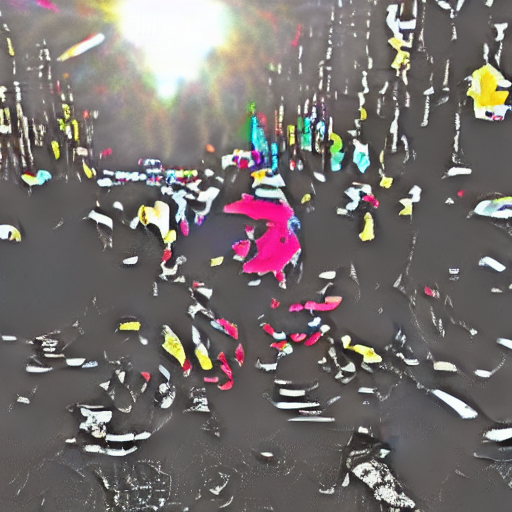

In [90]:
# Inference
#raise Exception
prompt = 'a tennis ball'
generated_img = eval_model(prompt, guidance_scale=7.5)
generated_img.save('test.png')
generated_img